## Setup

In [72]:
import pandas as pd
import numpy as np
import ruptures as rpt
import plotly.io as pio
import cufflinks as cf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser

pio.templates.default = "seaborn"
pd.options.plotting.backend = "plotly"

%matplotlib inline
%run global.ipynb

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [73]:
%store -r df
%store -r covid_cases

In [74]:
df

,id,gender,ageRange,occupation,compareDate,stepsEstimate,series,hour,steps,work_age,period,date
0,5ee39a5f5e886e000876182a,None,None,None,2020-03-16,NaN,2019-12-16,10,0.000000,False,Before,2019-12-16
1,5ee39a5f5e886e000876182a,None,None,None,2020-03-16,NaN,2019-12-16,11,48.000000,False,Before,2019-12-16
2,5ee39a5f5e886e000876182a,None,None,None,2020-03-16,NaN,2019-12-16,12,774.000000,False,Before,2019-12-16
3,5ee39a5f5e886e000876182a,None,None,None,2020-03-16,NaN,2019-12-16,13,679.500000,False,Before,2019-12-16
4,5ee39a5f5e886e000876182a,None,None,None,2020-03-16,NaN,2019-12-16,14,27.000000,False,Before,2019-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...
4858387,61af75effdde7a000853faad,Female,35-44,tjänsteman kommun,2020-03-16,-0.2,2021-02-16,05,6.750000,True,During,2021-02-16
4858388,61af75effdde7a000853faad,Female,35-44,tjänsteman kommun,2020-03-16,-0.2,2021-02-16,06,484.173828,True,During,2021-02-16
4858389,61af75effdde7a000853faad,Female,35-44,tjänsteman kommun,2020-03-16,-0.2,2021-02-16,07,1226.715031,True,During,2021-02-16
4858390,61af75effdde7a000853faad,Female,35-44,tjänsteman kommun,2020-03-16,-0.2,2021-02-16,08,209.611141,True,During,2021-02-16


In [75]:
df['date'] = pd.to_datetime(df['series'])

## Users

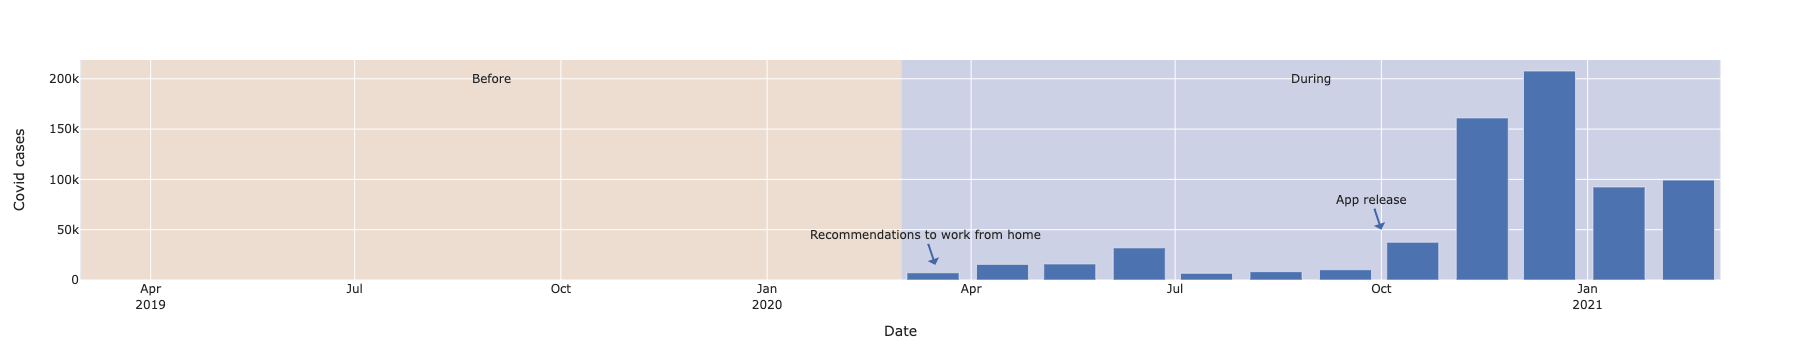

In [76]:
# covid_cases['scaled'] = covid_cases.cases / 125
fig = px.bar(x=covid_cases['date'], y=covid_cases['cases'], labels={ 'x': 'Date', 'y': 'Covid cases' })

fig.update_xaxes(
    dtick="M3",
    tickformat="%b\n%Y")

fig.add_annotation(x=parser.parse('2020-03-16'), y=15000,
            text="Recommendations to work from home",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=parser.parse('2020-10-01'), y=50000,
            text="App release",
            showarrow=True,
            arrowhead=1)

annotate_before_after(fig, True, 200000)

fig.update_layout(showlegend=False)
fig.show()

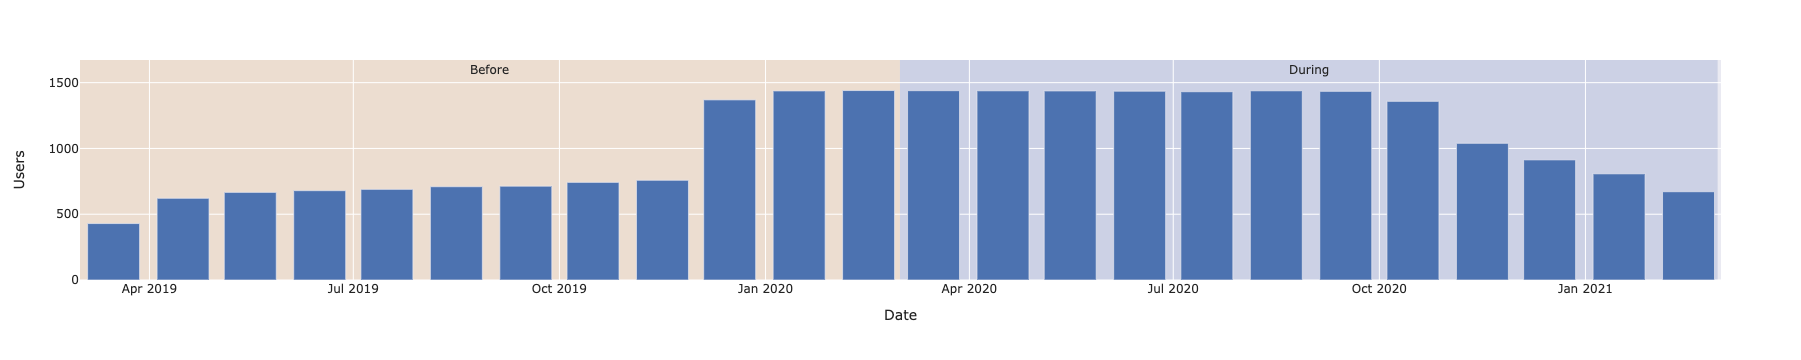

In [77]:
user_counts = df.groupby(['id','series','ageRange']).median().unstack('series')['steps'].count()

fig = px.bar(x=user_counts.index, y=user_counts, labels={ 'x': 'Date', 'y': 'Users' })

annotate_before_after(fig, True, 1600)

fig.show()

In [78]:
df = df[(df.date > '2018-09-16') & (df.date < '2021-03-01')]
df.groupby(['id','series']).median().unstack('series')['steps'].count()

series
2019-03-16     470
2019-04-16     731
2019-05-16     791
2019-06-16     809
2019-07-16     823
2019-08-16     844
2019-09-16     849
2019-10-16     884
2019-11-16     903
2019-12-16    1547
2020-01-16    1637
2020-02-16    1639
2020-03-16    1638
2020-04-16    1639
2020-05-16    1637
2020-06-16    1630
2020-07-16    1625
2020-08-16    1627
2020-09-16    1619
2020-10-16    1538
2020-11-16    1203
2020-12-16    1067
2021-01-16     958
2021-02-16     811
dtype: int64

## Steps each month

In [79]:
months = df.groupby(['hour','series']).median().unstack('series')['steps'].sum()

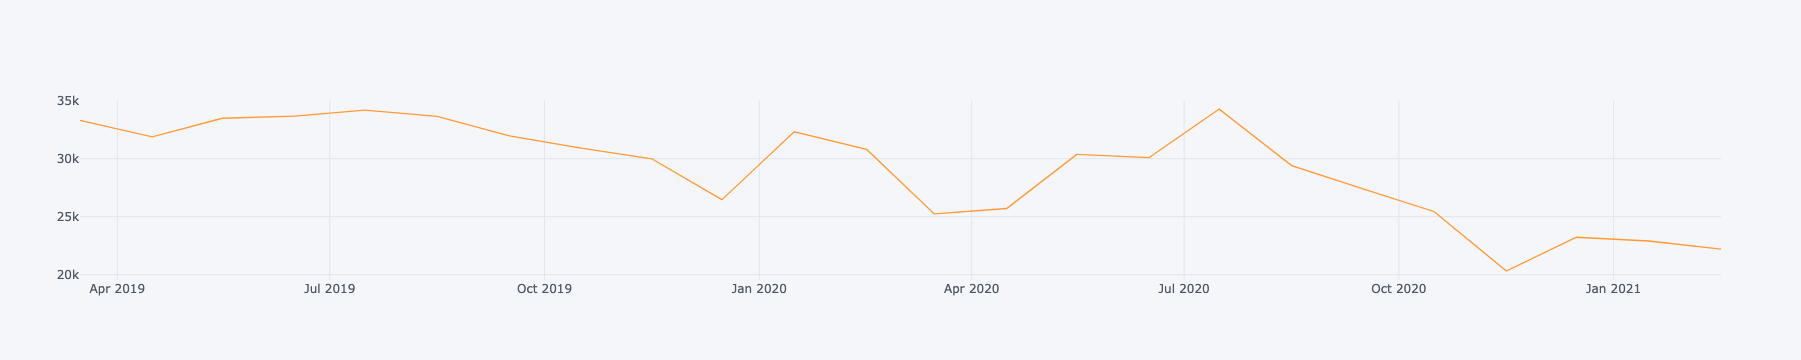

In [80]:
months.iplot()

## Calculate change each month

In [81]:
# period_before = df[df.date < '2020-03-01'].groupby(['hour','series']).median().unstack('series')['steps'].sum().median()
period_before = df[df['period'] == 'Before'].groupby(['hour','series']).median().unstack('series')['steps'].sum().median()

In [82]:
month_list = months.keys()
rows = []
for month in month_list:
    value = months[month]
    rows.append([month, value, value - period_before])
    
months_diff = pd.DataFrame(rows, columns=['month', 'steps', 'diff'])

In [83]:
months_diff['cu_sum'] = months_diff['diff'].cumsum()

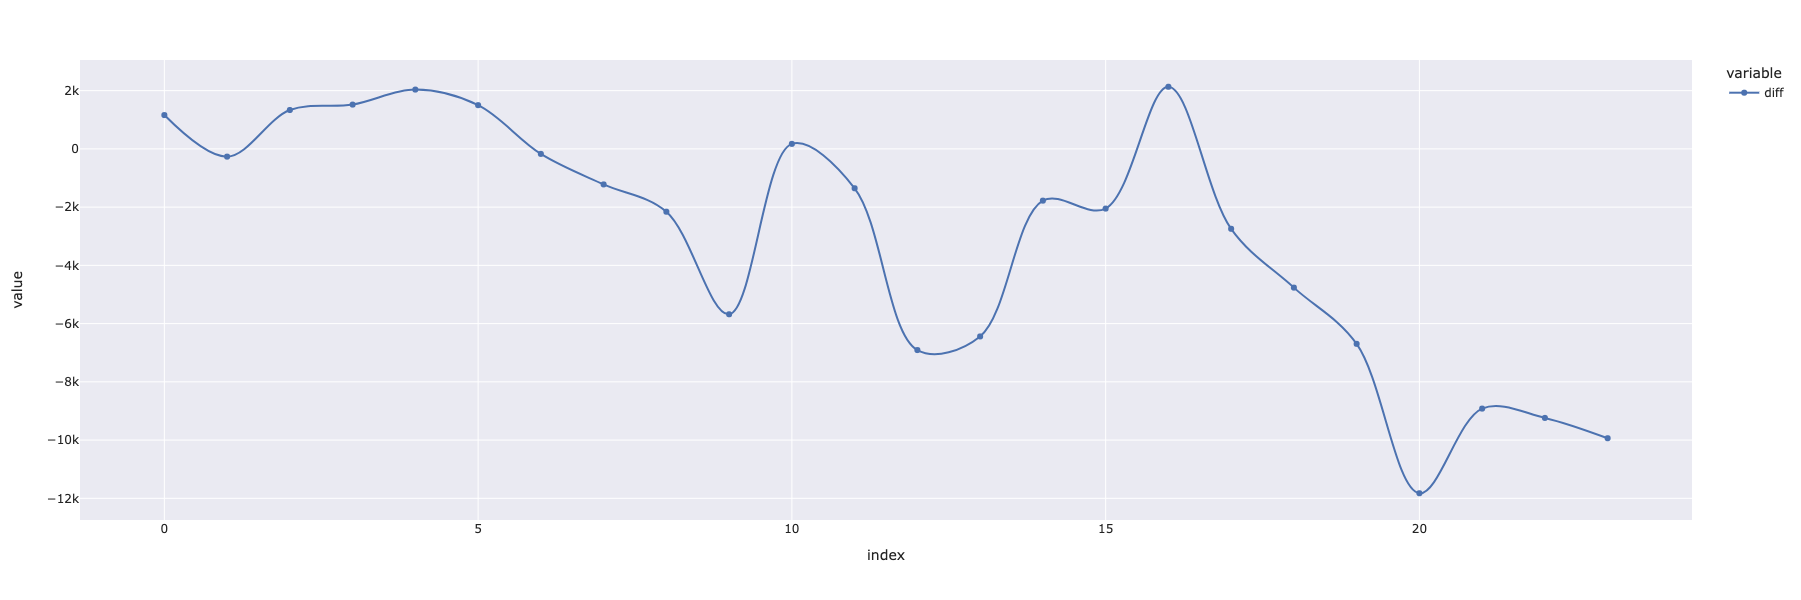

In [84]:
months_diff['diff'].plot.line(markers=True, line_shape='spline', height=600)

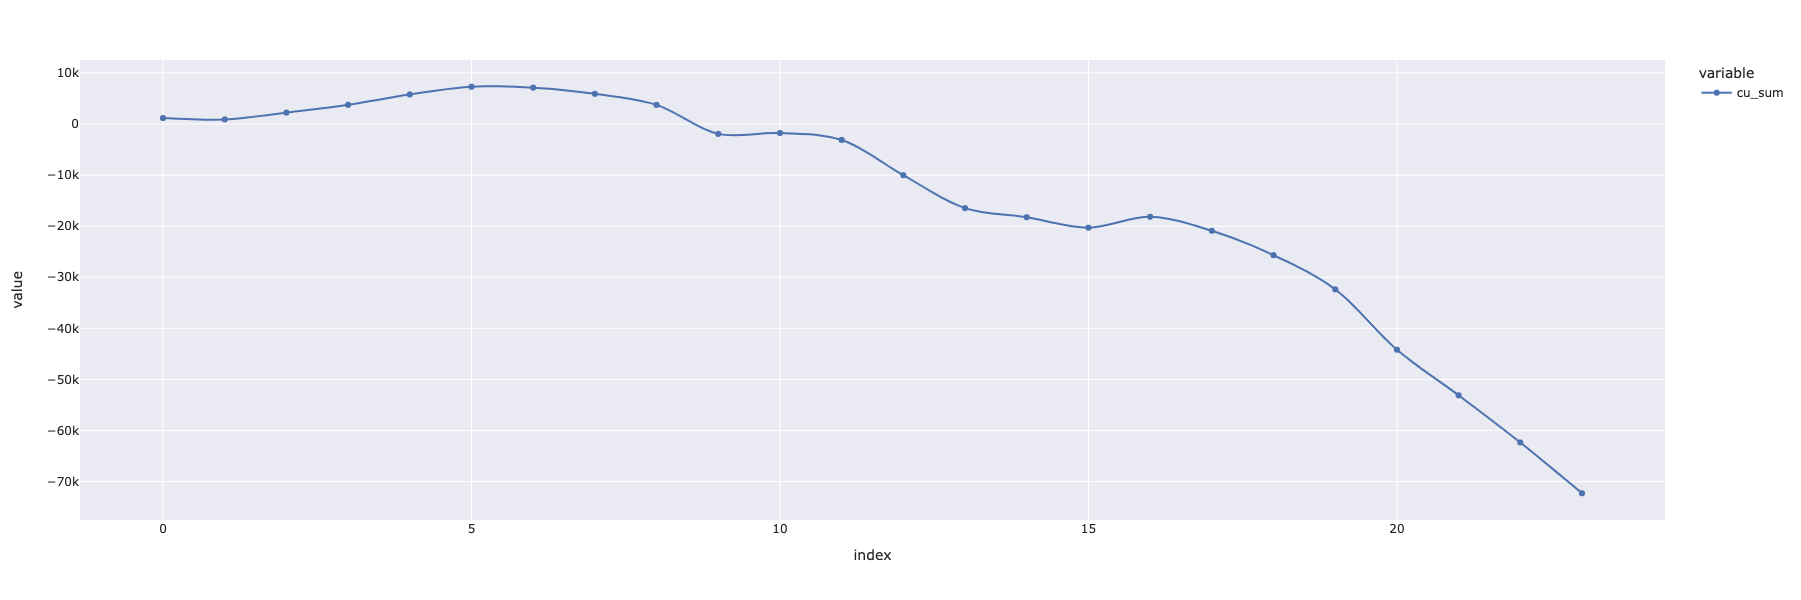

In [85]:
months_diff['cu_sum'].plot.line(markers=True, line_shape='spline', height=600)

## Steps over time vs Covid cases

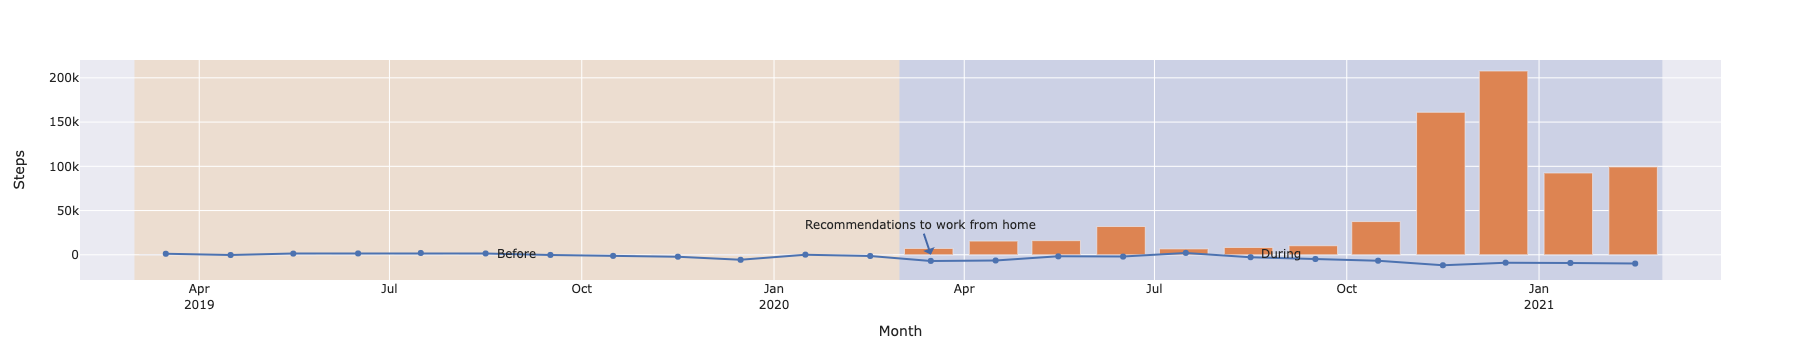

In [86]:
# covid_cases['scaled'] = covid_cases.cases / 125
fig = px.line(x=
              months_diff['month'], y=months_diff['diff'], markers=True)
fig.add_bar(x=covid_cases['date'], y=covid_cases['cases'])

fig.update_xaxes(
    title="Month",
    dtick="M3",
    tickformat="%b\n%Y")

fig.update_yaxes(title="Steps")

fig.add_annotation(x=parser.parse('2020-03-16'), y=100,
            text="Recommendations to work from home",
            showarrow=True,
            arrowhead=1)

annotate_before_after(fig)

fig.update_layout(showlegend=False)
fig.show()

/opt/conda/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




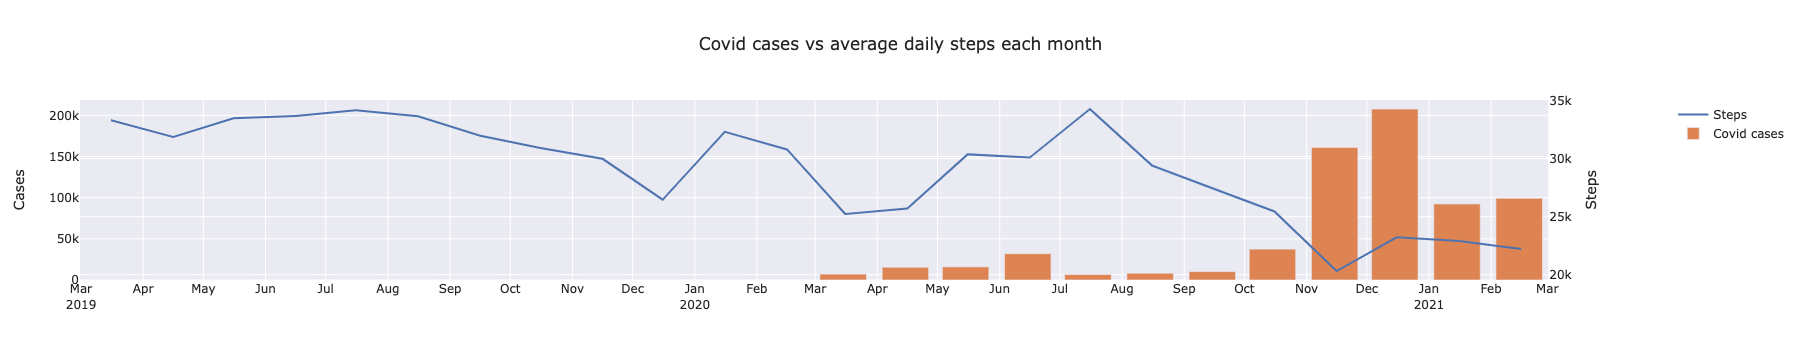

In [87]:
# covid_cases['scaled'] = covid_cases.cases / 150
fig = make_subplots(specs=[[{ "secondary_y": True }]])
fig.add_trace(go.Line(x=months_diff['month'], y=months_diff['steps'], name="Steps"), secondary_y=True,)
fig.add_trace(go.Bar(x=covid_cases['date'], y=covid_cases['cases'], name="Covid cases"), secondary_y=False,)
fig.update_layout(
    title_text="Covid cases vs average daily steps each month"
)
fig.update_yaxes(title_text="Cases", secondary_y=False)
fig.update_yaxes(title_text="Steps", secondary_y=True)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

fig.show()

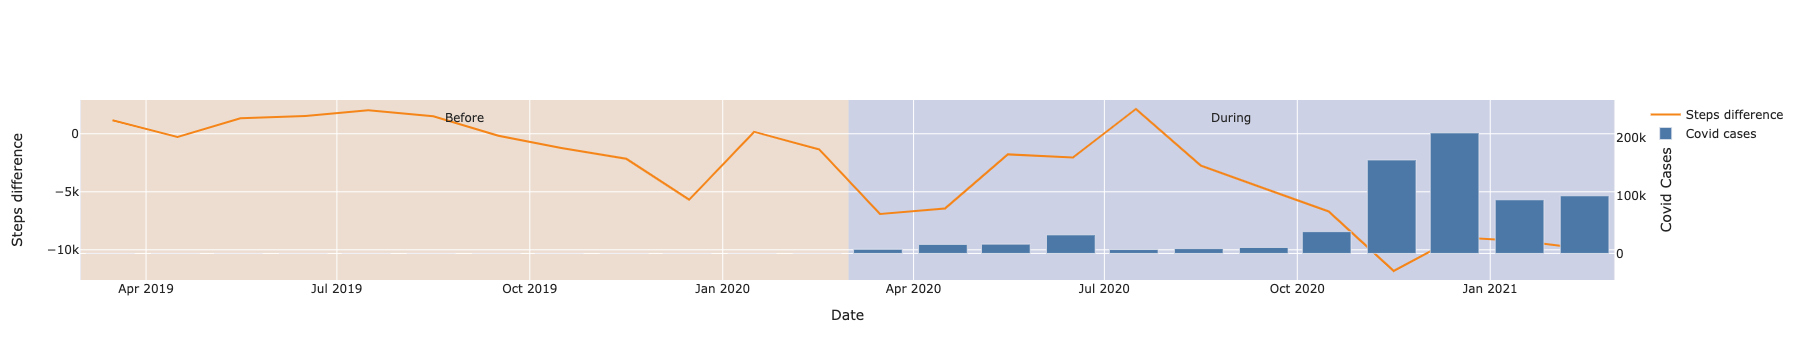

In [88]:
steps = go.Line(x=months_diff['month'], y=months_diff['diff'], name="Steps difference", mode="lines", line=dict(color=px.colors.qualitative.T10[1]))
cases = go.Bar(x=covid_cases['date'], y=covid_cases['cases'], name="Covid cases", yaxis='y2', marker_color=px.colors.qualitative.T10[0])


layout = go.Layout(xaxis=dict(title="Date"),
                   yaxis=dict(title='Steps difference', scaleanchor="y2", scaleratio=20),
                   yaxis2=dict(title='Covid Cases',
                               overlaying='y',
                               showgrid=False,
                               side='right'))

fig = go.Figure(data=[steps, cases], layout=layout)
annotate_before_after(fig)
fig.show()

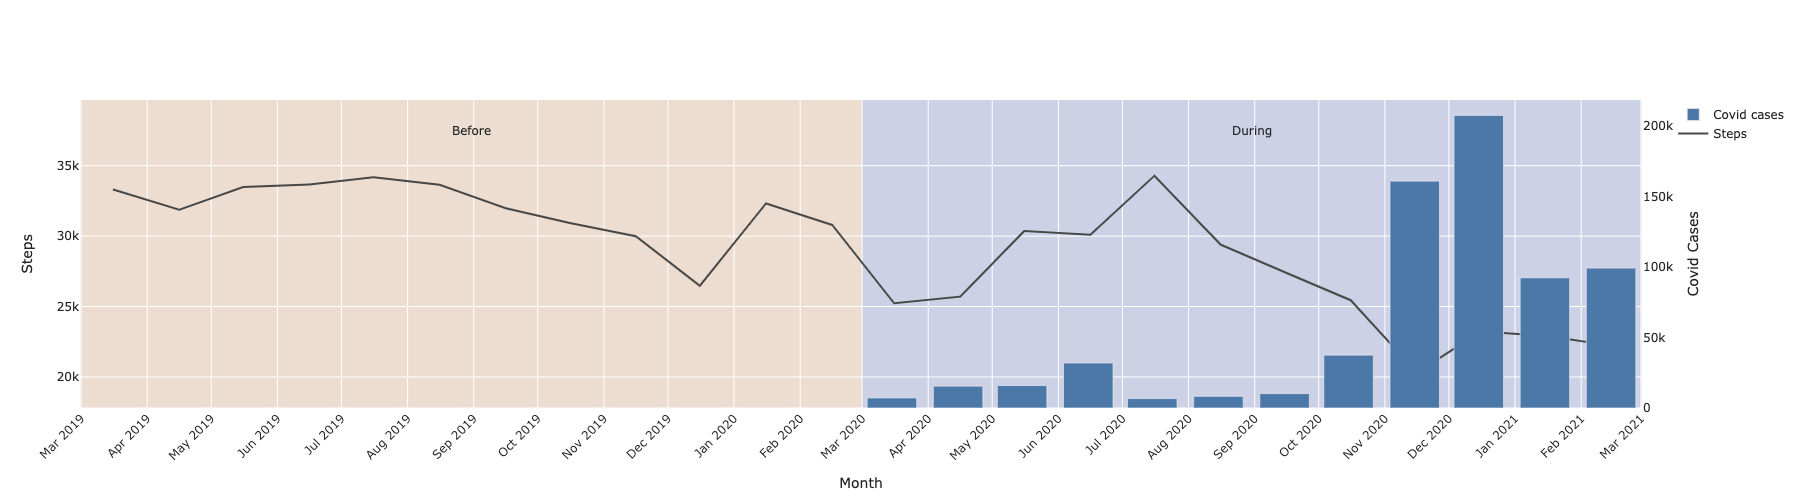

In [89]:
steps = go.Line(x=months_diff['month'], y=months_diff['steps'], name="Steps", mode="lines", line=dict(color='#474747'))
cases = go.Bar(x=covid_cases['date'], y=covid_cases['cases'], name="Covid cases", yaxis='y2', marker_color=px.colors.qualitative.T10[0], opacity=1)


# tickformat='%Y/%m'
layout = go.Layout(xaxis=dict(title="Month", tickmode='auto',tickangle=-45, nticks=30),
                   yaxis=dict(title='Steps', scaleanchor="y2", scaleratio=10),
                   yaxis2=dict(title='Covid Cases',
                               overlaying='y',
                               showgrid=False,
                               side='right'))

fig = go.Figure(data=[cases, steps], layout=layout)
# fig.data = (fig.data[1],fig.data[0])
# fig.update_layout(height=500, paper_bgcolor='#fff', plot_bgcolor="#fff")
fig.update_layout(height=500)

annotate_before_after(fig, True, 37500) 
fig.show()

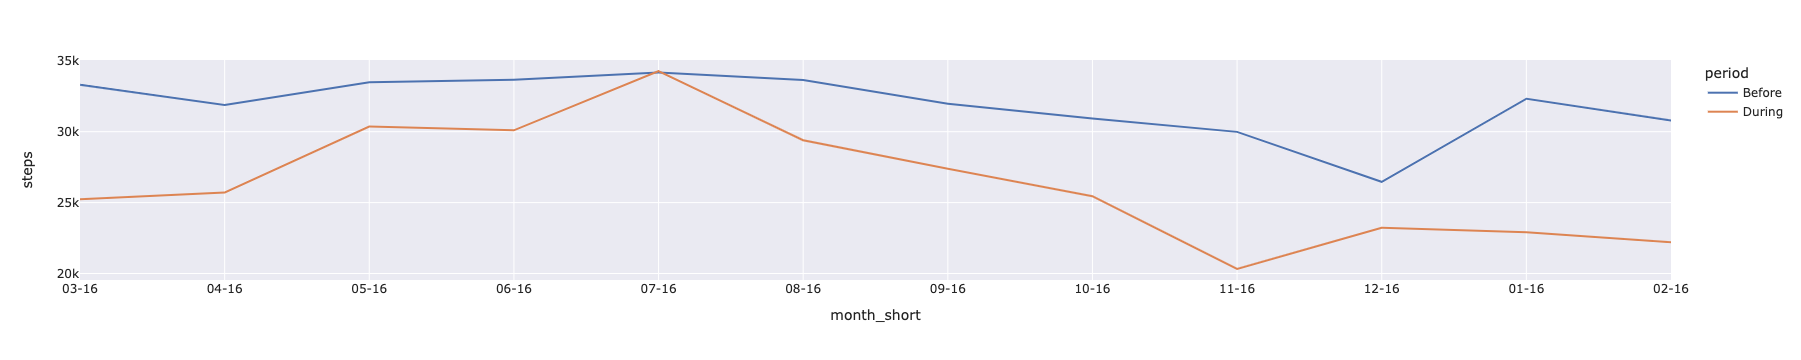

In [90]:
months_diff['period'] = np.select([
    (months_diff.month < '2020-03-16'),
    (months_diff.month >= '2020-03-16')
], ['Before', 'During'], default='none')
months_diff['month_short'] = months_diff['month'].str[5:]

months_diff.plot(x="month_short", y="steps", color="period")

/opt/conda/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




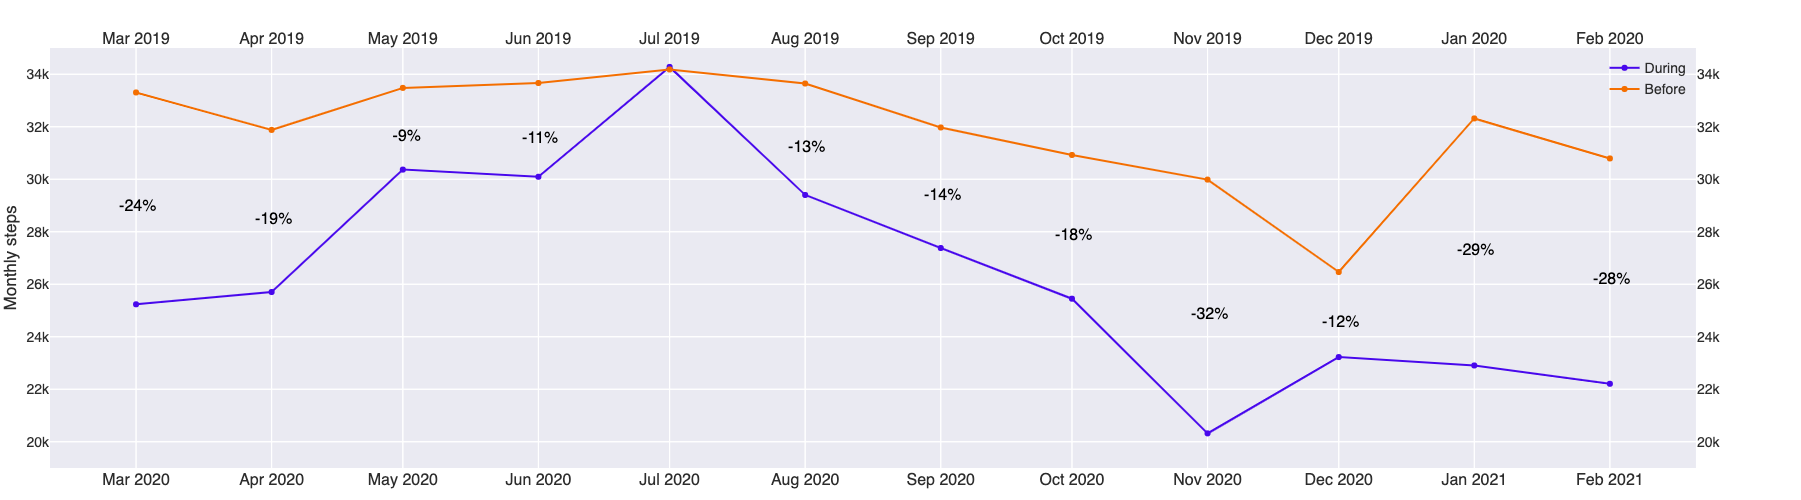

In [91]:
%run global.ipynb

months_before = months_diff[months_diff['period'] == 'Before']
months_during = months_diff[months_diff['period'] == 'During']


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'});

fig.add_trace(
    go.Line(x=months_during['month'],
           y=months_during['steps'],
           name="During",
           line_color=during_color
          ), secondary_y=False)
fig.add_trace(
    go.Line(x=months_before['month'],
           y=months_before['steps'],
               name="Before",
               line_color=before_color), secondary_y=True)
fig.data[1].update(xaxis='x2')
fig.update_layout(height=500)
fig.update_yaxes(range=[19000,35000])
fig.update_layout(xaxis=dict(tickvals=months_during.month, tickfont=dict(size=16)), xaxis2_tickformat = '%b %Y')
fig.update_layout(xaxis2=dict(tickvals=months_before.month, tickfont=dict(size=16)), xaxis_tickformat = '%b %Y')
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.update_layout(yaxis_title="Monthly steps")

style_plot(fig)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9375
))

annotateMonthDiffs(fig, months_before, months_during)

fig.show()

In [92]:
months_diff

,month,steps,diff,cu_sum,period,month_short
0,2019-03-16,33306.236495,1161.179653,1161.179653,Before,03-16
1,2019-04-16,31879.188780,-265.868062,895.311591,Before,04-16
2,2019-05-16,33480.317652,1335.260810,2230.572401,Before,05-16
3,2019-06-16,33666.259697,1521.202854,3751.775255,Before,06-16
4,2019-07-16,34181.952901,2036.896058,5788.671313,Before,07-16
5,2019-08-16,33646.771066,1501.714223,7290.385537,Before,08-16
6,2019-09-16,31972.757800,-172.299043,7118.086494,Before,09-16
7,2019-10-16,30924.937845,-1220.118997,5897.967497,Before,10-16
8,2019-11-16,29987.081212,-2157.975630,3739.991867,Before,11-16
9,2019-12-16,26465.610196,-5679.446646,-1939.454780,Before,12-16


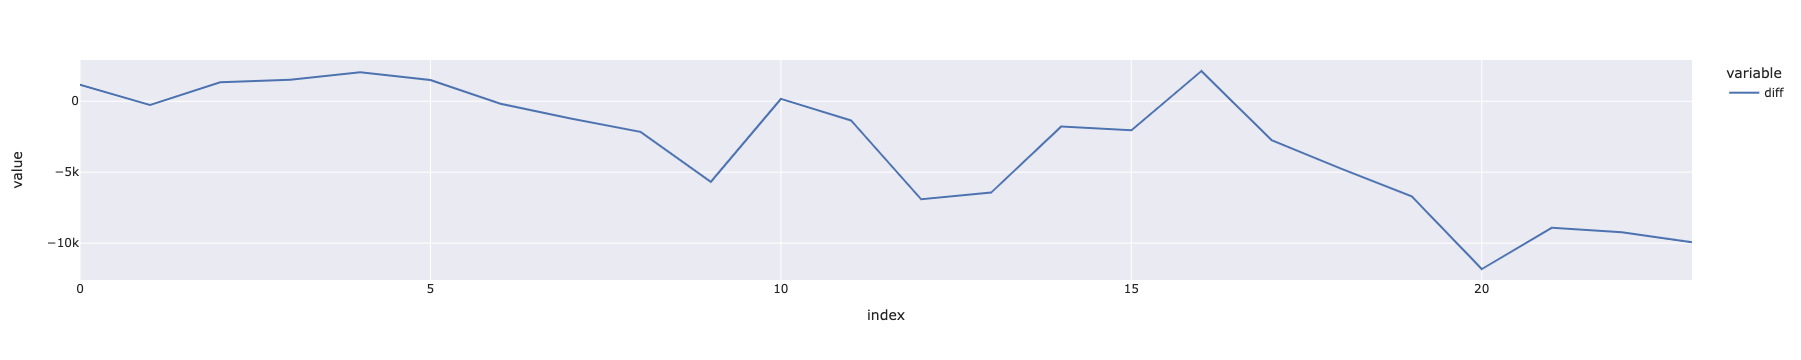

In [93]:
months_diff['diff'].plot()